<h1>European Football</h1>

<h2>Objective</h2>

* Investigate data set.
* Perform Data cleaning and exploratory data analysis.
* Perform statistical inference.
* Apply linear machine learning models to predict the Goal predictions and Winner outcomes.
* Create a dashboard.

<h3>Investigating the dataset</h3>

Dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european).
Supplementary dataset: [Supplementary Kaggle](https://www.kaggle.com/datasets/jiezi2004/soccer?select=goal_detail.csv).

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import missingno as msno

from scipy.stats import shapiro

from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import OLSInfluence

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc

import seaborn as sns

import textblob
from unidecode import unidecode

pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from tools import helpingtool

In [3]:
"""Setting graph parameters"""
sns.set(style='whitegrid')
sns.set_palette('flare')

In [4]:
alpha = 0.05

In [5]:
cnx = sqlite3.connect(r'..\Capstone\Archive\database.sqlite')
cursor = cnx.cursor()

helpingtool.sql_download(cursor)

Available tables: 

Table 'sqlite_sequence'
Features: ['name', 'seq']
Observations: 7 

Table 'Player_Attributes'
Features: ['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
Observations: 183978 

Table 'Player'
Features: ['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday', 'height', 'weight']
Observations: 11060 

Table 'Match'
Features: ['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_ap

In [6]:
match = pd.read_sql_query("""
                  SELECT 
                  m.id, league_id, season, stage, date, 
                  match_api_id, home_team_api_id, away_team_api_id, 
                  home_team_goal, away_team_goal, 
                  CASE 
                        WHEN home_team_goal > away_team_goal THEN 'home'
                        WHEN home_team_goal < away_team_goal THEN 'away'
                        ELSE 'draw' 
                  END AS win,
                          
                  home_player_X1, home_player_X2, home_player_X3, home_player_X4, home_player_X5, 
                  home_player_X6, home_player_X7, home_player_X8, home_player_X9, home_player_X10, home_player_X11, 
                  away_player_X1, away_player_X2, away_player_X3, away_player_X4, away_player_X5, 
                  away_player_X6, away_player_X7, away_player_X8, away_player_X9, away_player_X10, away_player_X11, 
                  home_player_Y1, home_player_Y2, home_player_Y3, home_player_Y4, home_player_Y5, 
                  home_player_Y6, home_player_Y7, home_player_Y8, home_player_Y9, home_player_Y10, home_player_Y11, 
                  away_player_Y1, away_player_Y2, away_player_Y3, away_player_Y4, away_player_Y5, 
                  away_player_Y6, away_player_Y7, away_player_Y8, away_player_Y9, away_player_Y10, away_player_Y11, 
                  home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, 
                  home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, 
                  away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, 
                  away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11
                  
                  FROM Match m

                  """, cnx)

In [7]:
for prefix in ['home_player_X', 'home_player_Y']:
    for feature in match.filter(like=prefix, axis=1).columns:
        match.loc[match[feature] == 0, feature] = np.NaN

In [8]:
player = pd.read_sql_query("""
                 SELECT 
                    *, 
                    ROUND(weight / ((height / 100) * (height / 100)), 1) AS bmi
                  FROM (
                  SELECT id, player_api_id, player_name, 
                           birthday, height, ROUND(weight / 2.2046, 1) AS weight
                  FROM Player
                  ) a
                  """, cnx)

In [9]:
player['birthday'] = pd.to_datetime(player['birthday'])

In [10]:
player_attributes = pd.read_sql_query("""
                  SELECT player_api_id, date, overall_rating, potential, preferred_foot,
                  (crossing + finishing + heading_accuracy + short_passing) AS attacking,
                  (dribbling + free_kick_accuracy + long_passing + ball_control) AS skill,
                  (acceleration + sprint_speed + reactions) AS movement,
                  (shot_power + stamina + strength + long_shots) AS power,
                  (aggression + interceptions + positioning + penalties) AS mentality,
                  (marking + standing_tackle) AS defending,
                  (gk_diving + gk_handling + gk_kicking + gk_positioning + gk_reflexes) AS goalkeeping

                  FROM Player_Attributes
                  """, cnx)

player_attributes = helpingtool.remove_empty_dupes(
    player_attributes, ['player_api_id', 'date'])
player_attributes['goalkeeping'] = np.log1p(player_attributes['goalkeeping'])

In [11]:
player_attributes['date'] = pd.to_datetime(player_attributes['date'])

In [12]:
player_attributes[['attacking', 'skill', 'movement', 'power',
                   'mentality', 'defending', 'goalkeeping'
                   ]] = MinMaxScaler().fit_transform(player_attributes[[
                                   'attacking', 'skill', 'movement', 'power',
                                   'mentality', 'defending', 'goalkeeping'
                                   ]])

In [13]:
team = pd.read_sql_query("""
                  SELECT team_api_id, team_long_name AS team_name
                  FROM Team
                  """, cnx)

In [14]:
team_attributes = pd.read_sql_query("""
                                    
                  SELECT *
                  FROM Team_Attributes
                                    
                  """, cnx)

In [15]:
team_attributes=helpingtool.dtype_update(team_attributes)

In [16]:
team_attributes = duckdb.query("""
             SELECT * 
             ,CASE 
             WHEN MONTH(date) > 6 THEN CONCAT(year, '/', year+1) 
             ELSE CONCAT(year - 1, '/', year)
             END AS season 
             FROM (
                SELECT *, YEAR(date) as year
                FROM team_attributes
             ) a
""").to_df()

In [17]:
league = pd.read_sql_query(""" 
                  SELECT l.id AS league_id, c.name AS Country, l.name AS League
                  FROM Country c
                  FULL OUTER JOIN League l
                  ON c.id=l.country_id
                  """, cnx)

In [18]:
cnx.close()

In [19]:
goal_detail = helpingtool.csv_download_match(r"goal")
card_detail = helpingtool.csv_download_match(r"card")

In [20]:
player = helpingtool.dtype_update(player)
player_attributes = helpingtool.dtype_update(player_attributes)
team = helpingtool.dtype_update(team)
team_attributes = helpingtool.dtype_update(team_attributes)
team_attributes.drop_duplicates(inplace=True)

match = helpingtool.dtype_update(match)
league = helpingtool.dtype_update(league)

In [21]:
player_positions = helpingtool.player_positions_extraction(match)

c:\Users\Gintare\Desktop\Study\Module2\Capstone\tools\helpingtool.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['type'] = prefix
c:\Users\Gintare\Desktop\Study\Module2\Capstone\tools\helpingtool.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['type'] = prefix
c:\Users\Gintare\Desktop\Study\Module2\Capstone\tools\helpingtool.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

<h1>Leagues and goal scores</h1>
Each of 11 counties have it's own League

In [22]:
league['League'] = league['League'].str.split(n=1).str[1]
league

,league_id,Country,League
0,1,Belgium,Jupiler League
1,1729,England,Premier League
2,4769,France,Ligue 1
3,7809,Germany,1. Bundesliga
4,10257,Italy,Serie A
5,13274,Netherlands,Eredivisie
6,15722,Poland,Ekstraklasa
7,17642,Portugal,Liga ZON Sagres
8,19694,Scotland,Premier League
9,21518,Spain,LIGA BBVA


Out of 11 Leagues, Spain (LIGA BBVA) is the top League for goals, while Switzerland (Super League) has the lowest scores.

In [23]:
league_detail = duckdb.query("""
             WITH 
             match_info AS (
             SELECT DISTINCT 
                             id, league_id, season, stage, 
                             date, match_api_id, team_goal, team_api_id, type, outcome
             FROM player_positions             
             )

             SELECT 
                             m.*, l.League, l.Country, t.team_name AS team_name, 
                             MONTH(date) AS month
             FROM match_info m
             LEFT JOIN league l ON l.league_id=m.league_id
             LEFT JOIN team t ON t.team_api_id=m.team_api_id
             """).to_df()

In [24]:
top_Leagues = league_detail.groupby(['season', 'Country'])[
    'team_goal'].sum().reset_index()
top_Leagues.groupby(['Country'])['team_goal'].sum().sort_values()

Country
Switzerland    4166
Poland         4656
Scotland       4804
Belgium        4841
Portugal       5201
Germany        7103
France         7427
Netherlands    7542
Italy          7895
England        8240
Spain          8412
Name: team_goal, dtype: int64

Looking closer to the goal sums per seasons, it seams that Belgium is having a dip at 2013/2014

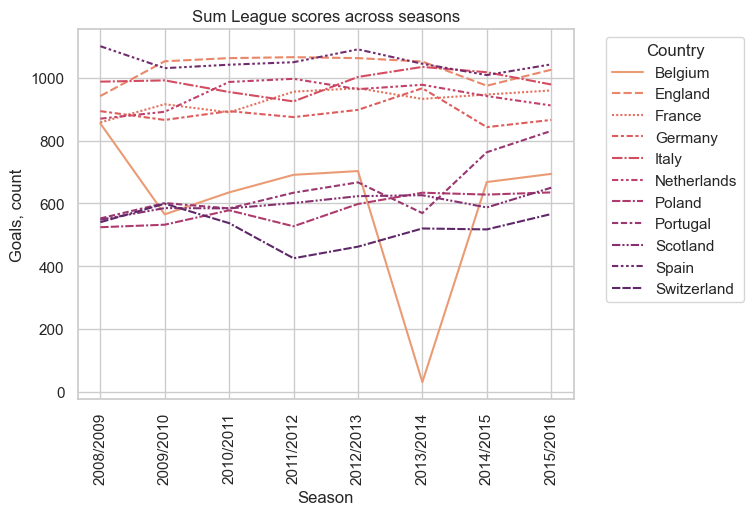

In [25]:
sns.color_palette("flare")

sns.lineplot(data=top_Leagues,
             x="season", y="team_goal", hue='Country', style='Country', palette='flare')

plt.xticks(rotation=90)

plt.xlabel("Season")
plt.ylabel("Goals, count")
plt.title("Sum League scores across seasons")

plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Goal sum drop in Belgium is due to a drop for 2013/2014. Belgium had only 6 stages, instead of 30. Internet search did not provide any information on Belgium League stop. This is probably missing data on Belgium for beginning of season and it can't be regarded as lowest scorer.

As seen in previous query, even with missing half the matches, Belgium is not the lowest League.

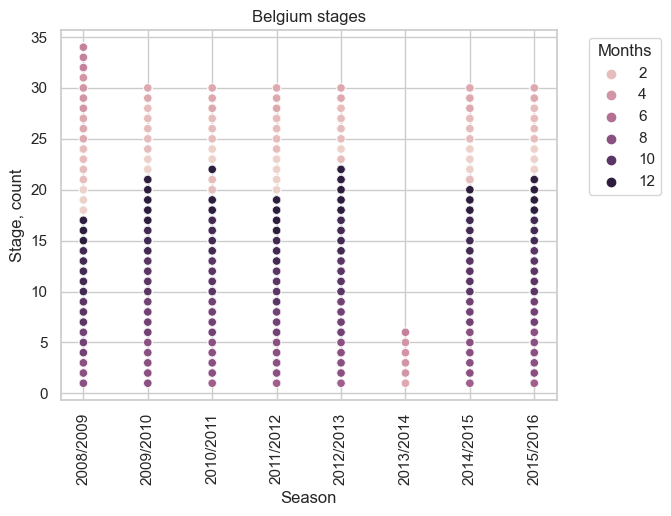

In [26]:
sns.color_palette("flare")

sns.scatterplot(data=league_detail[(league_detail['Country'] == 'Belgium')],
                x="season", y="stage", hue='month')

plt.xticks(rotation=90)

plt.xlabel("Season")
plt.ylabel("Stage, count")
plt.title("Belgium stages")
plt.legend(title='Months', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

<h1>Top teams in leagues</h1>
There's up to 35 teams per League

In [27]:
duckdb.query("""
             
            SELECT 
             Country, 
             COUNT(team_api_id) as team_per_League

            FROM (
             SELECT DISTINCT Country, team_api_id 
             FROM league_detail
             ) a

            GROUP BY Country
            ORDER BY COUNT(team_api_id) DESC
             
            """)

┌─────────────┬─────────────────┐
│   Country   │ team_per_League │
│   varchar   │      int64      │
├─────────────┼─────────────────┤
│ France      │              35 │
│ England     │              34 │
│ Spain       │              33 │
│ Italy       │              32 │
│ Germany     │              30 │
│ Portugal    │              29 │
│ Belgium     │              25 │
│ Netherlands │              25 │
│ Poland      │              24 │
│ Scotland    │              17 │
│ Switzerland │              15 │
├─────────────┴─────────────────┤
│ 11 rows             2 columns │
└───────────────────────────────┘

Each League has differences in their top scoring team:
* FC Barcelona from Spain scored up to 73 goals in 2011/2012 season
* Polonia Bytom scored 41 goals (less almost double) year prior.

In [28]:
duckdb.query("""
    WITH team_sum AS (
        SELECT
            season, Type, Country, team_name,
            SUM(team_goal) AS total_goals,
            RANK() OVER (PARTITION BY Country ORDER BY SUM(team_goal) DESC) as goal_rank
        FROM league_detail
        GROUP BY season, Type, Country, team_name
    )

    SELECT ts.season, ts.Type, ts.Country, ts.team_name, ts.total_goals
    FROM team_sum ts
    WHERE ts.goal_rank = 1
    ORDER BY total_goals DESC
""")

┌───────────┬─────────┬─────────────┬─────────────────────┬─────────────┐
│  season   │  type   │   Country   │      team_name      │ total_goals │
│  varchar  │ varchar │   varchar   │       varchar       │   int128    │
├───────────┼─────────┼─────────────┼─────────────────────┼─────────────┤
│ 2011/2012 │ home    │ Spain       │ FC Barcelona        │          73 │
│ 2009/2010 │ home    │ England     │ Chelsea             │          68 │
│ 2009/2010 │ home    │ Netherlands │ Ajax                │          64 │
│ 2015/2016 │ home    │ France      │ Paris Saint-Germain │          59 │
│ 2012/2013 │ home    │ Germany     │ FC Bayern Munich    │          56 │
│ 2015/2016 │ home    │ Scotland    │ Celtic              │          55 │
│ 2009/2010 │ home    │ Switzerland │ FC Basel            │          54 │
│ 2015/2016 │ home    │ Portugal    │ SL Benfica          │          52 │
│ 2015/2016 │ home    │ Italy       │ Napoli              │          49 │
│ 2008/2009 │ home    │ Belgium     │ 

Some Leagues have multiple best teams: 
* Teams with higher threshold: France, Germany, Netherlands, Portugal, Scotland and Spain have their best team score 8-10 goals/match
* Belgium, England, Italy, Poland, Switzerland have lower threshold for best teams, as top goals/match is 6-7.
* Lower threshold teams have up to 8 best teams (Poland)

In [29]:
duckdb.query("""
             SELECT stage, season, Country, team_name, team_goal, 
             count(team_goal) OVER (PARTITION BY team_name) as Top_Scoring_Team_event 
             FROM (
    SELECT DISTINCT stage, season, Country, team_name, team_goal
    FROM (
        SELECT
            t.*
             , RANK() OVER (PARTITION BY Country ORDER BY team_goal DESC) as goal_rank
        FROM league_detail t
    ) ranked_teams
    WHERE goal_rank = 1
             ) a
    ORDER BY Country, team_name
""").to_df()

,stage,season,Country,team_name,team_goal,Top_Scoring_Team_event
0,6,2015/2016,Belgium,Club Brugge KV,7,2
1,19,2012/2013,Belgium,Club Brugge KV,7,2
2,22,2014/2015,Belgium,KV Kortrijk,7,1
3,9,2008/2009,Belgium,RSC Anderlecht,7,1
4,17,2010/2011,Belgium,Standard de Liège,7,1
5,13,2009/2010,England,Tottenham Hotspur,9,1
6,30,2015/2016,France,Paris Saint-Germain,9,1
7,27,2012/2013,Germany,FC Bayern Munich,9,1
8,4,2013/2014,Italy,Inter,7,2
9,2,2014/2015,Italy,Inter,7,2


In data cleaning it was already established that team goal count in non-normal distribution. Thus Kruskal-Wallis Test (a non-parametric test that doesn't assume normality) was chosen to assesse whether the distributions of the different groups are the same or not. 

Null hypothesis: Different Leagues have the same mean goal amount per match. <br>
Alternative Hypotheses: Different Leagues have the different mean goal amount per match.<br>

In [30]:
result = kruskal(*[group['team_goal']
                 for name, group in league_detail.groupby('League')])

print("Kruskal-Wallis p-value:", result.pvalue)

if result.pvalue < alpha:
    print("Reject the null hypothesis: Leagues have different median goal amounts per match.")
else:
    print("Fail to reject the null hypothesis: Leagues have the same median goal amount per match.")

Kruskal-Wallis p-value: 1.390653906312617e-50
Reject the null hypothesis: Leagues have different median goal amounts per match.


<h1>Top player in teams and leagues</h1>
Prepating data from goal_detail supplementary dataset.

In [31]:
goal_detail = helpingtool.dummy_columns(goal_detail, ['goal_type'])

In [32]:
def key_player(player_id: str) -> pd.DataFrame:
    df = duckdb.query(f"""
            WITH 
            goal_player AS (
            SELECT 
                  match_id, CAST(team AS INT) as team_id, {player_id} AS player_id,
                  SUM(goal_type_dg + goal_type_npm + goal_type_rp + goal_type_psm) AS saved_goal,
                  SUM(goal_type_n + goal_type_p) AS goal,
                  SUM(goal_type_o) AS owngoal       
            FROM goal_detail
            WHERE {player_id} IS NOT NULL
            GROUP BY match_id, team_id, player_id
            )


            SELECT g.saved_goal, g.goal, g.owngoal
             ,p.player_api_id ,p.player_name, p.height, p.weight, p.BMI
             ,YEAR(l.date) - YEAR(p.birthday) AS age, l.date
             ,season, stage, team_goal, team_api_id, type, outcome, League, Country, team_name	
             
            FROM goal_player g
            JOIN player p ON p.player_api_id=g.player_id
            JOIN league_detail l ON g.match_id = l.id AND l.team_api_id = g.team_id
    """).to_df()
    return df


top_player = key_player('player1')
support_player = key_player('player2')

In [33]:
player_league = duckdb.query("""
             WITH player_desc AS (
             SELECT League, Country,  season, team_name, player_name, height, weight, bmi, age, date
             ,SUM(saved_goal) AS saved_goal
             ,SUM(goal) AS goal
             ,SUM(owngoal) AS owngoal
             FROM top_player
             GROUP BY League, Country,  season, team_name, player_name, height, weight, bmi, age, date
             )

             SELECT * FROM (
             SELECT *
             ,RANK() OVER (PARTITION BY Country ORDER BY saved_goal DESC) as saved_goal_rank
             ,RANK() OVER (PARTITION BY Country ORDER BY goal DESC) as goal_rank
             ,RANK() OVER (PARTITION BY Country ORDER BY owngoal DESC) as owngoal_rank
             FROM player_desc
            ) a 
""").to_df()

<h3>Most unlucky attacking players</h3>
Some players have not been so lucky as their goals have been not allowed or saved. Maximum amount of not allowed goals are up to 2 per match: England, France, Germany, Italy, Spain

In [34]:
player_league[
    (player_league['saved_goal_rank'] == 1)
    &
    (player_league['saved_goal'] > 1)
][[
    'League', 'Country', 'team_name',
    'player_name', 'saved_goal'
]].drop_duplicates().sort_values(by=['Country', 'saved_goal'])

,League,Country,team_name,player_name,saved_goal
7674,Premier League,England,Sunderland,Darren Bent,2.0
29157,Premier League,England,Bolton Wanderers,Kevin Davies,2.0
30637,Premier League,England,West Bromwich Albion,Saido Berahino,2.0
30638,Premier League,England,Middlesbrough,Tuncay Sanli,2.0
30639,Premier League,England,Everton,Jo,2.0
13406,Ligue 1,France,Paris Saint-Germain,Zlatan Ibrahimovic,2.0
16290,Ligue 1,France,Stade Rennais FC,Giovanni Sio,2.0
22786,1. Bundesliga,Germany,Borussia Dortmund,Pierre-Emerick Aubameyang,2.0
2926,Serie A,Italy,Juventus,Arturo Vidal,2.0
3087,Serie A,Italy,Genoa,Diego Milito,2.0


When cheecking 95% of having a not allowed goals, the confidence interval is close to 0. 
This shows that above players are outliers in their 2 not allowed goals per match.

In [35]:
helpingtool.confidence_intervals(player_league['saved_goal'])

Confidence Interval: [0.03, 0.04]


<h3>Most lucky players</h3>
When looking at most scoring players per match, England, France, Germany, Italy is again in the front - some players score up to 5 goals per match.

Looking at data cleaning and team_goal distribution, it was seen that team goals > 5 are an outlier. Also, statistically 95% confidence can be applied when assuming that 1 attacking role player makes 1.6-1.07 goals per match. Thus, 5 goals from a person is truly impressive.

In [36]:
helpingtool.confidence_intervals(player_league['goal'])

Confidence Interval: [1.06, 1.07]


In [37]:
player_league[
    (player_league['goal_rank'] == 1)
    &
    (player_league['goal'] != 0)
][['League', 'Country', 'team_name', 'player_name', 'goal']].drop_duplicates().sort_values(by=['Country', 'goal'])

,League,Country,team_name,player_name,goal
7559,Premier League,England,Manchester United,Dimitar Berbatov,5.0
7560,Premier League,England,Manchester City,Sergio Aguero,5.0
9001,Premier League,England,Tottenham Hotspur,Jermain Defoe,5.0
13924,Ligue 1,France,OGC Nice,Carlos Eduardo,5.0
28933,1. Bundesliga,Germany,FC Bayern Munich,Robert Lewandowski,5.0
17262,Serie A,Italy,Lazio,Miroslav Klose,5.0
23181,Eredivisie,Netherlands,FC Utrecht,Sebastien Haller,4.0
23568,Eredivisie,Netherlands,Heracles Almelo,Oussama Tannane,4.0
23820,Eredivisie,Netherlands,AZ,Vincent Janssen,4.0
9007,Ekstraklasa,Poland,Lech Poznań,Artjoms Rudnevs,3.0


<h3>Most confussed players</h3>
Jonathan Walters - England, Aissa Mandi - France and Karim Haggui - Germany, these players have had 2 owngoals per 1 match.

In [38]:
player_league[
    (player_league['owngoal_rank'] == 1)
    &
    (player_league['owngoal'] > 1)
][['League', 'Country', 'team_name', 'player_name', 'owngoal'
   ]].drop_duplicates().sort_values(by=['Country', 'owngoal'])

,League,Country,team_name,player_name,owngoal
0,Premier League,England,Stoke City,Jonathan Walters,2.0
12037,Ligue 1,France,Stade de Reims,Aissa Mandi,2.0
24838,1. Bundesliga,Germany,Hannover 96,Karim Haggui,2.0


95% confidence interval for having an owngoal shows that such expectation falls close to 0.

In [39]:
helpingtool.confidence_intervals(player_league['owngoal'])

Confidence Interval: [0.03, 0.03]


<h3>Most supporting players</h3>
Most supporting players are in England, but this finding could be due to low fixation of events and helping players. This could also represent the supporting playing style in English Football.

In [40]:
support = duckdb.query("""
             SELECT 
                       season, Country, team_name, player_name, 
                       COUNT(player_name) AS Players_helped
             FROM support_player
             GROUP BY Country, team_name, player_name, season
             ORDER BY COUNT(player_name) DESC
""").to_df()

support.head(10)

,season,Country,team_name,player_name,Players_helped
0,2015/2016,England,Arsenal,Mesut Oezil,16
1,2014/2015,France,Olympique de Marseille,Dimitri Payet,16
2,2014/2015,England,Chelsea,Cesc Fabregas,16
3,2011/2012,England,Manchester City,David Silva,15
4,2010/2011,England,Manchester United,Nani,15
5,2011/2012,Spain,Real Madrid CF,Mesut Oezil,15
6,2014/2015,Germany,VfL Wolfsburg,Kevin de Bruyne,14
7,2009/2010,England,Chelsea,Frank Lampard,14
8,2010/2011,Spain,Real Madrid CF,Mesut Oezil,13
9,2015/2016,France,Paris Saint-Germain,Angel Di Maria,13


In [41]:
support.loc[support['Country'] != 'England', 'Country'] = 'Other'

Null hypothesis: England has the same amount of helping players as other Leagues. <br>
Alternative Hypotheses: England has a different amount of helping players than other Leagues.<br>

In [42]:
helpingtool.category_Mann_Whitney_U_test(
    support, 'Players_helped', 'Country', 'England', 'Other')

p-value = 0.0000 between Players_helped and Country. Reject null hypothesis


The difference between England and other countries helping player count is obvious, but it's still not clear if English games have more data due to better even registration.

<h3>Player change team</h3>
In the previous example it was seen that Mesut Oezil changed teams between Real Madrid CF and Arsenal. Almost half of all players in this study (4690 / 11060) change teams at least 1 time.

In [43]:
player.shape[0]

11060

In [44]:
team_change = duckdb.query("""
             WITH 
             team_change AS (             
             SELECT 
                           player AS player_api_id, 
                           COUNT(DISTINCT team_api_id) AS team_count
             FROM player_positions 
             WHERE player IS NOT NULL
             GROUP BY player
             )

             SELECT t.team_count, p.player_name, p.player_api_id
             FROM team_change t
             JOIN player p ON p.player_api_id=t.player_api_id
""").to_df()

team_change[team_change['team_count'] > 1].shape[0]

4690

There's players that have changed teams up to 7 times (8 teams meaning 1st then 7 additional), but the 75% quartile is 1 change per observation period.

In [45]:
team_change[['team_count']].describe()

,team_count
count,11060.000000
mean,1.677848
std,0.967188
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000


In [46]:
team_player_changes=duckdb.query("""
             SELECT 
                c.team_count, t.player_name, t.age, t.date, t.stage, 
                t.team_goal, t.type, t.outcome, t.League, t.Country, t.team_name, t.goal
             FROM team_change c
             JOIN top_player t ON c.player_api_id=t.player_api_id
             """).to_df()

Null hypothesis: Players who change team have the same goal count as those who don't change team. <br>
Alternative Hypotheses: Players who change team have the different goal count as those who don't change team.<br>

In [47]:
helpingtool.category_Mann_Whitney_U_test(
    team_player_changes, 'goal', 'team_count', 1, 2)

p-value = 0.0007 between goal and team_count. Reject null hypothesis


Null hypothesis: Teams that have players from other teams have the same goal count as those without foreign players. <br>
Alternative Hypotheses: Teams that have players from other teams have the different goal count as those without foreign players.<br>

In [48]:
helpingtool.category_Mann_Whitney_U_test(
    team_player_changes, 'team_goal', 'team_count', 1, 2)

p-value = 0.0009 between team_goal and team_count. Reject null hypothesis


<h4>Conclussion</h4>
High goal count player as sought after by teams.

<h3>Player starting position and goal event position</h3>
Do teams that have scoring players move around more have a better chance of a win?

Null Hypothesis: Player leaving their starting X position has no effect on win outcome.

Alternative Hypothesis: Player leaving their starting X position has a significant effect on win outcome.

In [49]:
player_positions

,id,league_id,win_team,season,stage,date,match_api_id,team_goal,team_api_id,X,Y,player,type,outcome
0,1,1,draw,2008/2009,1,2008-08-17,492473,1,9987,NaN,NaN,NaN,home,draw
1,2,1,draw,2008/2009,1,2008-08-16,492474,0,10000,NaN,NaN,NaN,home,draw
2,3,1,away,2008/2009,1,2008-08-16,492475,0,9984,NaN,NaN,NaN,home,loss
3,4,1,home,2008/2009,1,2008-08-17,492476,5,9991,NaN,NaN,NaN,home,win
4,5,1,away,2008/2009,1,2008-08-16,492477,1,7947,NaN,NaN,NaN,home,loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571533,25975,24558,home,2015/2016,9,2015-09-22,1992091,0,10191,5.0,11.0,289732.0,away,loss
571534,25976,24558,away,2015/2016,9,2015-09-23,1992092,2,10199,7.0,10.0,95257.0,away,win
571535,25977,24558,home,2015/2016,9,2015-09-23,1992093,0,10179,5.0,11.0,275122.0,away,loss
571536,25978,24558,draw,2015/2016,9,2015-09-22,1992094,0,10243,5.0,11.0,194532.0,away,draw


In [50]:
goal_inspection = duckdb.query("""

             SELECT *
                ,CASE WHEN win_team = p.type THEN 0 ELSE 1 END AS win
                ,ABS(pos_y - Y) AS dY -- likelyhood of moving
                ,ABS(pos_x - X) AS dX
             FROM player_positions p
             JOIN goal_detail g ON 
                               g.match_id = p.id 
                               AND g.team = p.team_api_id 
                               AND g.player1 = p.player 
                               AND g.pos_x IS NOT NULL

             """).to_df()

In [51]:
helpingtool.significance_t_test(goal_inspection, 'dX', 'win', 0, 1)

p-value = 0.7022 between dX and win. Fail to reject null hypothesis


Null Hypothesis: Player pleaving their starting Y position has no effect on win outcome.

Alternative Hypothesis: Player pleaving their starting Y position has a significant effect on win outcome.

In [52]:
helpingtool.significance_t_test(goal_inspection, 'dY', 'win', 0, 1)

p-value = 0.0000 between dY and win. Reject null hypothesis


In [54]:
goal_inspection[~goal_inspection['dY'].isna()][['league_id']].value_counts()

league_id
21518        1912
1729         1870
10257        1850
4769         1760
7809         1598
13274         841
dtype: int64

<h4>Conclussion</h4>
Players (that move around on Y axis) and team scores are correlareted. But such data on players are available only on 6/11 leagues and will not be used.

<h3>Home advantage</h3>
Null hypothesis: No home advantage is observed between home and away matches. <br>
Alternative Hypotheses: These is a home advantage between home and away matches.<br>

In [55]:
player_positions = helpingtool.dummy_columns(player_positions, 'outcome')

In [56]:
home_advantage = duckdb.query("""
             SELECT DISTINCT 
                    team_api_id, match_api_id, type, draw, loss, win
             FROM player_positions
             """).to_df()

In [57]:
helpingtool.category_Mann_Whitney_U_test(
    home_advantage, 'win', 'type', 'home', 'away')

p-value = 0.0000 between win and type. Reject null hypothesis


<h4>Conclussion</h4>
Home advantage is real.

<h3>Season and stage</h3>
Null hypothesis: Season and stage features do not have a correlation relationship with goal count. <br>
Alternative Hypotheses: Season and stage features do have a correlation relationship with goal count.<br>

In [58]:
goals_per_team = duckdb.query("""

             SELECT *
             FROM league_detail l
             RIGHT JOIN team_attributes a ON 
             l.team_api_id=a.team_api_id AND l.season=a.season
             WHERE l.season NOT IN ('2008/2009')


             """).to_df()

In [59]:
for tested_feature in ['season', 'stage']:

    helpingtool.spearmans_corr(goals_per_team, ['team_goal', tested_feature])

team_goal + season. p-value = 0.0063: Spearman's correlation:  0.0141
Reject null hypothesis
team_goal + stage. p-value = 0.0231: Spearman's correlation:  0.0117
Reject null hypothesis


Null hypothesis: League and stage do not have a correlation relationship with season. <br>
Alternative Hypotheses: League and stage do not have a correlation relationship with season.<br>

In [60]:
for tested_feature in ['League', 'stage']:

    helpingtool.spearmans_corr(goals_per_team, ['season', tested_feature])

season + League. p-value = 0.0213: Spearman's correlation:  0.0119
Reject null hypothesis
season + stage. p-value = 0.1022: Spearman's correlation:  0.0084
Fail to reject null hypothesis


<h4>Conclusion</h4>

* High goal count player as sought after by teams.
* Players (that move around on Y axis) and team scores are correlated. But such data on players are available only on 6/11 leagues and will not be used.
* Home games have home advantage.
* Season and stage has influence on team_goal. This is probably  team changing attributes through years.
* Stage and season are not correlated, but League and season are weakly correlated. This shows that season is a good partition point for time series related model.

<h1>Model</h1>
<h2>Goals per match</h2>
Goals per match and other features will be examined with linear regression model.

In data cleaning it was seen that team attribute features for categories are replicas of continues features. Categorical features will be used when continues features are not available. It was also seen that features are correlated among each other, but it's not clear which of them are important for team_goal model.

Data is split into half on 2013, model is trained on 2009-2013 data and tested on 2013-2016. The data is standardized to have zero mean and standard deviation of one to improve numerical stability of the model.

Significance level: 0.05

Assumptions for the linear regression are fulfilled or will be checked.

* Normally distributed residuals. This will be checked.
* Homoscedasticity, do the residuals have constant variation against target values? Will be checked.
* Observations are independent from each other.
* Enough large sample size.
* Multicollinearity among the independent variables.

In [61]:
team_rating = duckdb.query("""

    WITH 
    player_positions_with_rating AS (
        SELECT
            pp.id,
            pp.season,
            pp.date,
            pp.match_api_id,
            pp.team_api_id,
            pp.player,
            pp.type,
            pp.win,
            a.overall_rating,
            a.attacking, a.skill, a.movement, a.power, a.mentality, a.defending, a.goalkeeping
        FROM player_positions pp
        LEFT JOIN player_attributes a ON a.player_api_id = pp.player AND a.date = pp.date
    )
                               

    SELECT
        id,
        season,
        date,
        match_api_id,
        team_api_id,
        player,
        type,
        win,
        overall_rating, attacking, skill, movement, power, mentality, defending, goalkeeping
    FROM player_positions_with_rating

""").to_df()

In [62]:
missing_rating = duckdb.query("""
                               
    WITH                                      
    missing_rating AS (
    SELECT date, player, 
    overall_rating, attacking, skill, movement, power, mentality, defending, goalkeeping
    FROM team_rating  
    WHERE overall_rating IS NULL
    )

    ,available_ratings AS (           
    SELECT a.date, a.player_api_id AS player, 
    a.overall_rating, a.attacking, a.skill, a.movement, a.power, a.mentality, a.defending, a.goalkeeping
    FROM player_attributes a
    RIGHT JOIN missing_rating m ON m.player=a.player_api_id
    )

    ,joined_tables AS (
    SELECT * FROM missing_rating
    UNION ALL
    SELECT * FROM available_ratings
    )
                               
    SELECT DISTINCT * FROM joined_tables
    ORDER BY date
             
""").to_df()

Without filling missing data, only 162 rows are usable. Filling in the missing attributes based on date and player.

In [63]:
for feature in ['overall_rating', 'attacking', 'skill', 'movement', 'power', 'mentality', 'defending', 'goalkeeping']:
    missing_rating[feature] = missing_rating.groupby('player')[feature].ffill()
    missing_rating[feature] = missing_rating.groupby('player')[feature].bfill()

In [64]:
final_team_rating = duckdb.query("""
             WITH 
             good_team_rating AS (    
                SELECT date, player, overall_rating, attacking, skill, movement, power, mentality, defending, goalkeeping
                FROM team_rating
                WHERE overall_rating IS NOT NULL
             )

             ,missing_team_rating AS (    
                SELECT date, player, overall_rating, attacking, skill, movement, power, mentality, defending, goalkeeping
                FROM team_rating
                WHERE overall_rating IS NULL
             )

             ,missing_filled AS (
             SELECT m.date, m.player, m.overall_rating, m.attacking, m.skill, m.movement, m.power, m.mentality, m.defending, m.goalkeeping
             FROM missing_rating m
             RIGHT JOIN missing_team_rating t ON m.date=t.date AND m.player=t.player
             )
                               
            ,final AS (
             SELECT * FROM missing_filled
             UNION ALL 
             SELECT * FROM good_team_rating
            )
                               

             SELECT DISTINCT
             pp.id, pp.season, pp.date, pp.match_api_id, pp.team_api_id, pp.player, pp.type, pp.win, pp.Y

            ,a.overall_rating, a.attacking, a.skill, a.movement, a.power, a.mentality, a.defending, a.goalkeeping
             
             FROM player_positions pp
             LEFT JOIN final a ON a.player=pp.player AND a.date=pp.date
             WHERE a.overall_rating IS NOT NULL 

             
""").to_df()

In [65]:
goals_per_team = duckdb.query("""
             WITH
             players_score AS (
             SELECT match_api_id, team_api_id
                              
             , SUM(overall_rating) AS players_score
             , SUM(attacking) AS attacking
             , SUM(skill) AS skill
             , SUM(movement) AS movement
             , SUM(power) AS power
             , SUM(mentality) AS mentality
             , SUM(defending) AS defending
             , SUM(goalkeeping) AS goalkeeping
                                                            
             , COUNT(player) AS player_count
             FROM final_team_rating
             GROUP BY match_api_id, team_api_id
             )

             SELECT t.*, s.players_score, s.attacking, s.skill, s.movement, s.power, s.mentality, s.defending, s.goalkeeping
             FROM goals_per_team t
             JOIN players_score s ON s.match_api_id=t.match_api_id AND s.team_api_id=t.team_api_id
             WHERE s.player_count = 11

             """).to_df()

Separating a copy of dataframe for the future use in logistical model.

In [66]:
goals_per_team_home = goals_per_team[goals_per_team['type'] == 'home'].drop(
    columns='type')

Encoding choosen categorical features.

In [67]:
enocded_columns = ['type', 'outcome', 'buildUpPlayPositioningClass',
                   'chanceCreationPositioningClass', 'defenceDefenderLineClass']


df_dummies = pd.get_dummies(goals_per_team[enocded_columns], drop_first=True)

goals_per_team = pd.concat([goals_per_team, df_dummies], axis=1)

In [68]:
encoded_columns = ['type_home', 'buildUpPlayPositioningClass_Organised',
                   'chanceCreationPositioningClass_Organised', 'defenceDefenderLineClass_Offside Trap']
non_enocoded_columns = [
    'attacking', 'skill', 'movement', 'power', 'mentality', 'defending', 'goalkeeping',
    'buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing',
    'chanceCreationShooting',
    'defencePressure', 'defenceAggression', 'defenceTeamWidth']

# Scalling the Continues features so they have the same scale
goals_per_team[non_enocoded_columns] = MinMaxScaler(
).fit_transform(goals_per_team[non_enocoded_columns])

Creating model for all 18 features.

In [69]:
X = goals_per_team[encoded_columns + non_enocoded_columns]
y = goals_per_team['team_goal']


# Split the data into training and testing sets based on 'season'
train_data = goals_per_team[goals_per_team['season'].isin(
    ['2009/2010', '2010/2011', '2011/2012'])]
test_data = goals_per_team[~goals_per_team['season'].isin(
    ['2009/2010', '2010/2011', '2011/2012'])]

x_train = X.loc[train_data.index]
y_train = y.loc[train_data.index]

x_test = X.loc[test_data.index]
y_test = y.loc[test_data.index]

# Add a constant term to the features
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)


# Fit a linear model

model = sm.OLS(y_train, x_train)

result = model.fit()


# Print the summary

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              team_goal   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     76.06
Date:                Mon, 12 Feb 2024   Prob (F-statistic):          1.01e-268
Time:                        19:57:11   Log-Likelihood:                -27108.
No. Observations:               16832   AIC:                         5.425e+04
Df Residuals:                   16813   BIC:                         5.440e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

Information Criterion, R^2 (Coefficient of determination) and Condition number are used for model competition. The lower the Information Criterion and Condition number - the better. Larger R^2 indicates a better fit between the model and the observed data.

* Training Model on all 18 features show R^2 = 0.074. 
* Condition number assess the numerical stability of a matrix. It is larger than 30 (71.5), which show that model is suffering from Multicollinearity.
* Akaike Information Criterion (AIC) penalizes the model for the number of parameters included. AIC = 5.425e+04.
* Bayesian Information Criterion (BIC) is similar to AIC, but imposes a harsher penalty for model complexity. BIC = 5.440e+04.


Predictors for which the null hypothesis can not be rejected are:

* movement
* power
* mentality
* goalkeeping  
* buildUpPlaySpeed
* chanceCreationPassing
* chanceCreationShooting
* defenceAggression 
* buildUpPlayPassing 

Multicollinear features attacking and skill will be seprated and only attacking used.

In [70]:
X = goals_per_team[['type_home', 'buildUpPlayPositioningClass_Organised',
                    'chanceCreationPositioningClass_Organised', 'defenceDefenderLineClass_Offside Trap', 'attacking',
                    'defending', 'defencePressure', 'defenceTeamWidth']]

y = goals_per_team['team_goal']



# Split the data into training and testing sets based on 'season'

# For example, use '2009/2010' and '2010/2011' for training and '2011/2012' for testing

train_data = goals_per_team[goals_per_team['season'].isin(
    ['2009/2010', '2010/2011', '2011/2012'])]

test_data = goals_per_team[~goals_per_team['season'].isin(
    ['2009/2010', '2010/2011', '2011/2012'])]


x_train = X.loc[train_data.index]

y_train = y.loc[train_data.index]


x_test = X.loc[test_data.index]

y_test = y.loc[test_data.index]


# Add a constant term to the features

x_train = sm.add_constant(x_train)

x_test = sm.add_constant(x_test)


# Fit a linear model

model = sm.OLS(y_train, x_train)

result = model.fit()


# Print the summary

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              team_goal   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     164.7
Date:                Mon, 12 Feb 2024   Prob (F-statistic):          1.29e-268
Time:                        19:57:12   Log-Likelihood:                -27132.
No. Observations:               16832   AIC:                         5.428e+04
Df Residuals:                   16823   BIC:                         5.435e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

The model is created using 8 attributes. 
* R^2 values stayed at 0.072, which shows low model accuracy. 
* Conditional number decreased to acceptable 22.3.
* AIC and BIC have not changed and show high model complexity.


Next, the models performance is assessed.

In [71]:
helpingtool.y_pred, y_pred_rounded = helpingtool.predictions(result, x_test)
helpingtool.evaluation(y_pred_rounded, y_test)

R-squared Validation: -0.0036
Mean Absolute Error (MAE): 0.9290
Mean Squared Error (MSE): 1.5851


After testing, MSE values are high, this shows model is not on the accurate side. Also, visual inspection of residuals show that out of all available goal values (0-10), only values 0-1-2 is predicted correctly. This could be due to goal being non normal distributed, with values 0-1-2 represented the most.

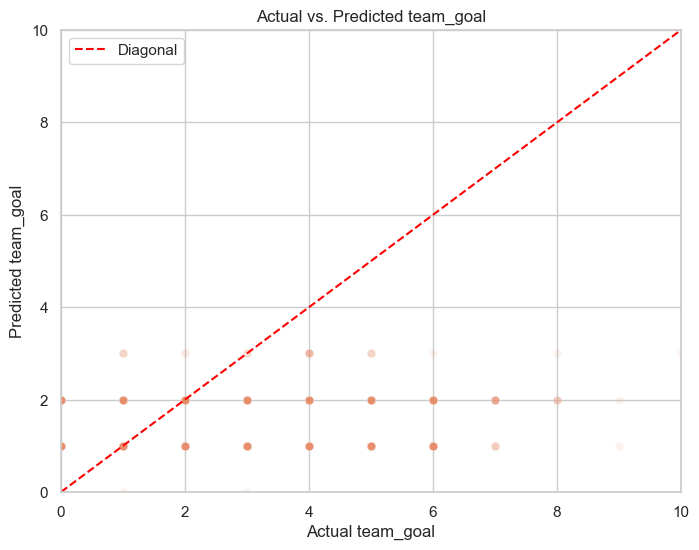

In [72]:
helpingtool.visualization_fitted_model(
    goals_per_team, y_test, y_pred_rounded, 'team_goal')

In [73]:
correct_predictions = (y_test == y_pred_rounded).sum()
incorrect_predictions = len(y_test) - correct_predictions

# Calculate percentage
total_predictions = len(y_test)
accuracy_percentage = (correct_predictions / total_predictions) * 100
error_percentage = (incorrect_predictions / total_predictions) * 100

# Print the results
print(f'Number of correct predictions: {correct_predictions}')
print(f'Number of incorrect predictions: {incorrect_predictions}')
print(f'Accuracy: {accuracy_percentage:.2f}%')
print(f'Error rate: {error_percentage:.2f}%')

Number of correct predictions: 5544
Number of incorrect predictions: 11937
Accuracy: 31.71%
Error rate: 68.29%


Variance of residuals are not distributed normally. Assumptions of homoscedasticity are not fulfilled. Additional columns could help, but all available columns have been tested.

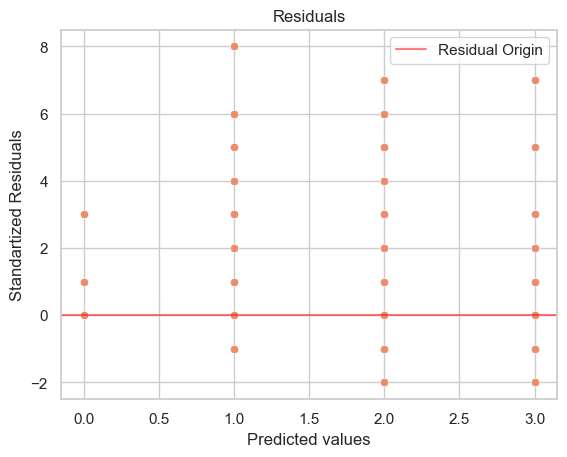

In [74]:
helpingtool.residual_plot(y_test, y_pred_rounded)

Normally distributed residual assumption is checked visually. Q-Q lot shows not normal distribution.

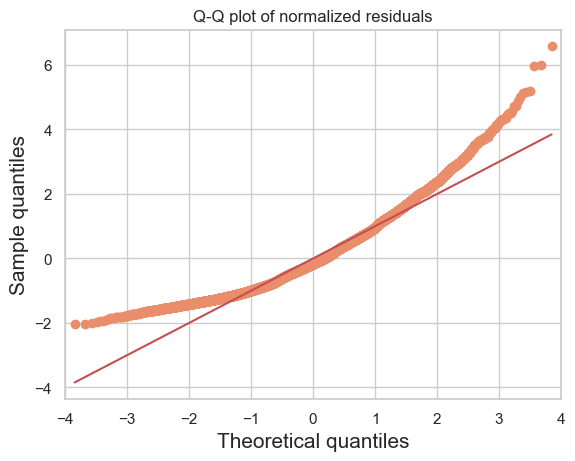

In [75]:
sm.qqplot(result.resid_pearson, line='s')
plt.xlabel("Theoretical quantiles", fontsize=15)
plt.ylabel("Sample quantiles", fontsize=15)
plt.title("Q-Q plot of normalized residuals")
plt.show()

Outlier check for influence on model are determined by Cook's distance with threshold of 4/N. Below, Cook's distance is plotted for all the observations in the training set together with index value.

In [76]:
cook_threshold = 4 / len(y_pred_rounded)
cook_threshold

0.00022881986156398376

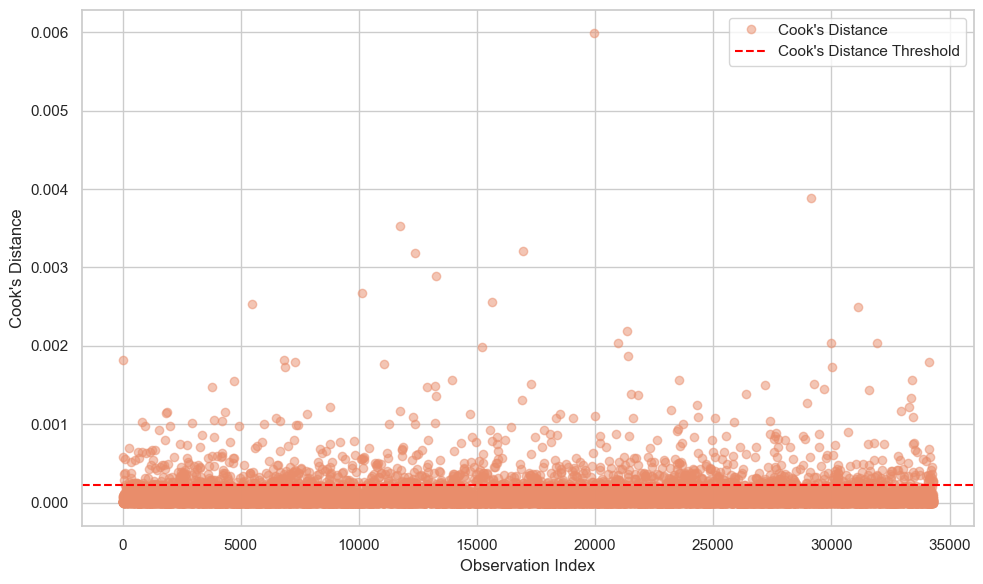

In [77]:
# Assuming result is the logistic regression result object
influence = result.get_influence()
cook_distances = influence.summary_frame().loc[:, ["cooks_d"]]

# Set a Cook's distance threshold (you should define cook_threshold)
cook_threshold = 4 / len(y_test)

# Plot Cook's distances
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cook_distances.index,
        cook_distances["cooks_d"], 'o', alpha=0.5, label="Cook's Distance")
ax.axhline(y=cook_threshold, ls="--", color="red",
           label="Cook's Distance Threshold")

# Add labels and legend
ax.set_xlabel('Observation Index')
ax.set_ylabel("Cook's Distance")
ax.legend()

# Tighten layout for better presentation
fig.tight_layout()

plt.show()

Number of observations that exceed Cook's distance threshold is 6%, which is high.

In [78]:
outliers = cook_distances[cook_distances.values > cook_threshold]
prop_outliers = round(100 * (len(outliers) / len(x_train)), 1)
print(f"{prop_outliers}%")

6.0%


In [79]:
goals_per_team['team_goal'].describe()['mean']

1.3877830559846123

<h2>Conclusion</h2>
The model is not performing optimally since the mean of goals per match is ~1.4 and is not normally distributed, but the model best predicts values 0-1-2. Although accuracy from tested data on time series split is ~32%, the outliers are high and this model could be improved for guessing values above 2 goals per match.
The model showed that player attributes and team composition is driving the team performance. There's also home advantage, which would fall under psychological safety. Mentality and psychological stability was not accounted in the model. 

When making a bet, it is safe to bet higher scoring leagues, like England and Spain to score more point per match.

<h2>Match winner for home playing team</h2>

Match winner and other features will be examined with logistic  regression model. The data was handled the same was as linear model. Target data is home team, as the combined probability between home and away teams = 1.

* Target team: home team

Assumptions for the logistic regression are fulfilled.

* Target variable is binary.
* Observations are independent from each other.
* Enough large sample size.
* Multicollinearity among the independent variables.

In [80]:
goals_per_team_home = goals_per_team[goals_per_team['type'] == 'home']

Dataset notates 1 as win and 0 as loss or draw.

In [81]:
goals_per_team_home[['type', 'outcome', 'outcome_win']].drop_duplicates()

,type,outcome,outcome_win
0,home,win,1
2,home,draw,0
4,home,loss,0


Winning/loosing outcome is relatively balanced.

In [82]:
goals_per_team_home['outcome_win'].value_counts()

0    9099
1    8078
Name: outcome_win, dtype: int64

Starting from 17 features to build the model.

In [83]:
encoded_columns = ['buildUpPlayPositioningClass_Organised',
                   'chanceCreationPositioningClass_Organised', 'defenceDefenderLineClass_Offside Trap']
non_enocoded_columns = [
    'attacking', 'skill', 'movement', 'power', 'mentality', 'defending', 'goalkeeping',
    'buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing',
    'chanceCreationShooting',
    'defencePressure', 'defenceAggression', 'defenceTeamWidth']

# Scalling the Continues features so they have the same scale
goals_per_team_home[non_enocoded_columns] = MinMaxScaler(
).fit_transform(goals_per_team_home[non_enocoded_columns])

C:\Users\Gintare\AppData\Local\Temp\ipykernel_9656\2156614578.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goals_per_team_home[non_enocoded_columns] = MinMaxScaler(


In [84]:
goals_per_team_home['win_outcome'] = goals_per_team_home['outcome_win'].astype(
    int)

C:\Users\Gintare\AppData\Local\Temp\ipykernel_9656\2914512166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goals_per_team_home['win_outcome'] = goals_per_team_home['outcome_win'].astype(


In [85]:
X = goals_per_team_home[encoded_columns + non_enocoded_columns]
y = goals_per_team_home['win_outcome']


# Split the data into training and testing sets based on 'season'
train_data = goals_per_team_home[goals_per_team_home['season'].isin(
    ['2009/2010', '2010/2011', '2011/2012'])]
test_data = goals_per_team_home[~goals_per_team_home['season'].isin(
    ['2009/2010', '2010/2011', '2011/2012'])]

x_train = X.loc[train_data.index]
y_train = y.loc[train_data.index]

x_test = X.loc[test_data.index]
y_test = y.loc[test_data.index]

# Add a constant term to the features
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# Fit a logistic regression model
model = sm.Logit(y_train, x_train)
result = model.fit()

# Print the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.667927
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            win_outcome   No. Observations:                 8432
Model:                          Logit   Df Residuals:                     8414
Method:                           MLE   Df Model:                           17
Date:                Mon, 12 Feb 2024   Pseudo R-squ.:                 0.03536
Time:                        20:00:15   Log-Likelihood:                -5632.0
converged:                       True   LL-Null:                       -5838.4
Covariance Type:            nonrobust   LLR p-value:                 3.794e-77
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.8

Based on the training results and significance level, four of eleven predictors do not have significant relationship with the dependent variable. These are:
* buildUpPlayPassing
* chanceCreationPassing 
* defenceAggression
* defenceDefenderLineClass Trap
* attacking
* movement
* power   
* mentality     
* goalkeeping

Features with significantly linear relationship with log-odds of the probability to be classified as a high quality wine are:

* buildUpPlayPositioningClass_Organised
* chanceCreationPositioningClass_Organised 
* skill
* defending 
* buildUpPlaySpeed
* chanceCreationShooting 
* defencePressure
* defenceTeamWidth

For these predictors, the null hypothesis can be rejected.

In [86]:
for i in ['buildUpPlayPositioningClass_Organised', 'chanceCreationPositioningClass_Organised',
          'skill', 'defending', 'buildUpPlaySpeed', 'chanceCreationShooting',
          'defencePressure', 'defenceTeamWidth']:
    goals_per_team_home[i] = goals_per_team_home[i].astype(float)

C:\Users\Gintare\AppData\Local\Temp\ipykernel_9656\695578432.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goals_per_team_home[i] = goals_per_team_home[i].astype(float)


Some of the picked variables are multicollinear among each other, so buildUpPlayPositioningClass_Organised and defending will be removed.

In [87]:
helpingtool.vif(goals_per_team_home[['buildUpPlayPositioningClass_Organised', 'chanceCreationPositioningClass_Organised',
                                     'skill', 'defending', 'buildUpPlaySpeed', 'chanceCreationShooting',
                                     'defencePressure', 'defenceTeamWidth']])

,variables,VIF
0,buildUpPlayPositioningClass_Organised,13.567384
1,chanceCreationPositioningClass_Organised,8.431733
2,skill,18.775604
3,defending,21.929057
4,buildUpPlaySpeed,8.854203
5,chanceCreationShooting,9.929060
6,defencePressure,8.711570
7,defenceTeamWidth,8.518016


In [88]:
X = goals_per_team_home[['chanceCreationPositioningClass_Organised',
                         'skill', 'buildUpPlaySpeed', 'chanceCreationShooting',
                         'defencePressure', 'defenceTeamWidth'
                         ]]
y = goals_per_team_home['win_outcome']


train_data = goals_per_team_home[goals_per_team_home['season'].isin(
    ['2009/2010', '2010/2011', '2011/2012'])]
test_data = goals_per_team_home[~goals_per_team_home['season'].isin(
    ['2009/2010', '2010/2011', '2011/2012'])]

x_train = X.loc[train_data.index]
y_train = y.loc[train_data.index]

x_test = X.loc[test_data.index]
y_test = y.loc[test_data.index]

# Add a constant term to the features
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# Fit a logistic regression model
model = sm.Logit(y_train, x_train)
result = model.fit()

# Print the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.670132
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            win_outcome   No. Observations:                 8432
Model:                          Logit   Df Residuals:                     8425
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Feb 2024   Pseudo R-squ.:                 0.03217
Time:                        20:00:16   Log-Likelihood:                -5650.6
converged:                       True   LL-Null:                       -5838.4
Covariance Type:            nonrobust   LLR p-value:                 4.733e-78
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.1

* Pseudo R-squared: 0.03217 - a relatively low value, indicating that the model may not be explaining a substantial portion of the variability.

* The LLR (Likelihood Ratio Test) p-value is 4.733e-78, indicating that the model as a whole is statistically significant compared to a null model (a model with no predictors).

This logistical model is mostly predicting losses.

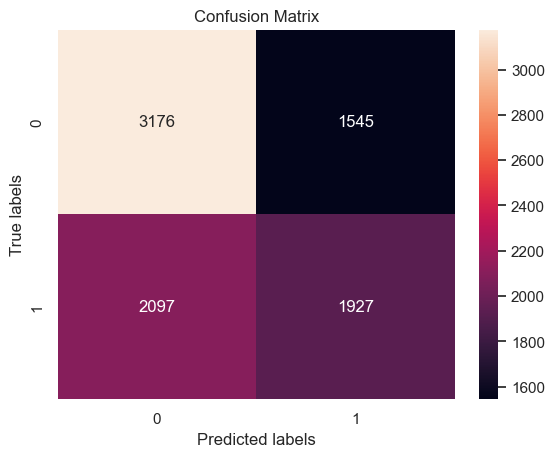

In [89]:
helpingtool.y_pred, y_pred_rounded = helpingtool.predictions(result, x_test)
helpingtool.confusion_matrix_visual(y_test, y_pred_rounded, ['0', '1'])

Accuracy rate is ~59%.

In [90]:
correct_predictions = (y_test == y_pred_rounded).sum()
incorrect_predictions = len(y_test) - correct_predictions

# Calculate percentage
total_predictions = len(y_test)
accuracy_percentage = (correct_predictions / total_predictions) * 100
error_percentage = (incorrect_predictions / total_predictions) * 100

# Print the results
print(f'Number of correct predictions: {correct_predictions}')
print(f'Number of incorrect predictions: {incorrect_predictions}')
print(f'Accuracy: {accuracy_percentage:.2f}%')
print(f'Error rate: {error_percentage:.2f}%')

Number of correct predictions: 5103
Number of incorrect predictions: 3642
Accuracy: 58.35%
Error rate: 41.65%


Receiver Operating Characteristic (ROC)

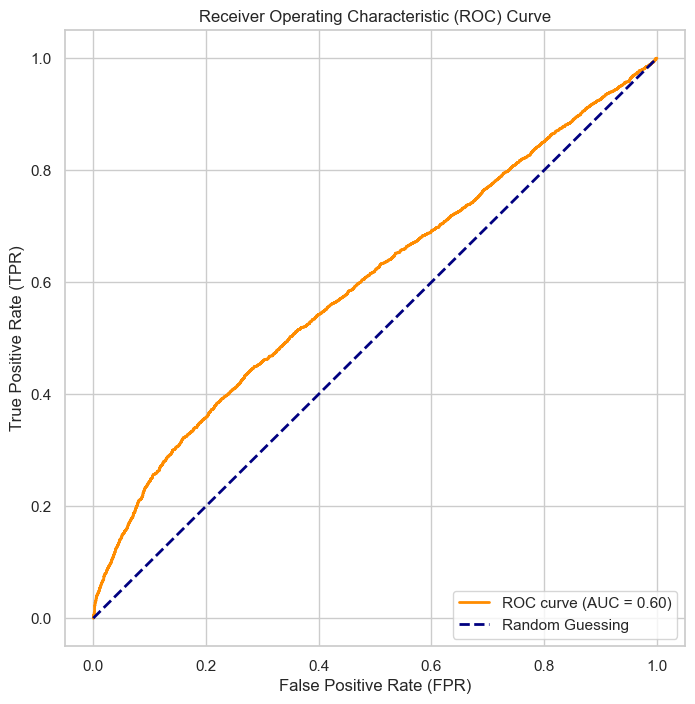

In [91]:
y_prob = result.predict(x_test)

# Compute ROC curve and area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2,
         linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The area under the ROC curve is 0.6 - the model has some ability to distinguish, but it's closer to random chance.

In [92]:
cook_threshold = 4 / len(y_prob)
cook_threshold

0.00045740423098913663

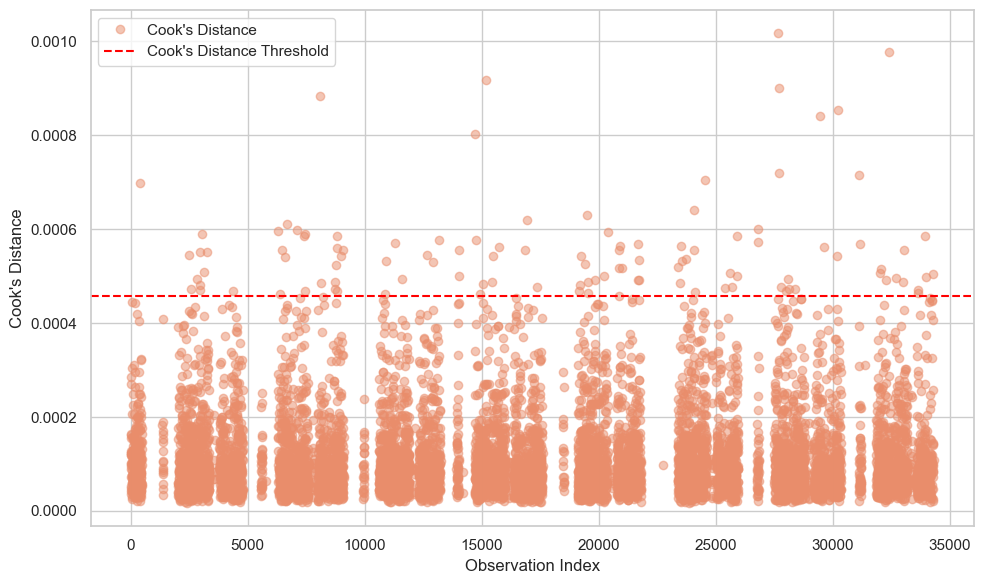

In [93]:
# Assuming result is the logistic regression result object
influence = result.get_influence()
cook_distances = influence.summary_frame().loc[:, ["cooks_d"]]

# Set a Cook's distance threshold (you should define cook_threshold)
cook_threshold = 4 / len(y_test)

# Plot Cook's distances
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cook_distances.index,
        cook_distances["cooks_d"], 'o', alpha=0.5, label="Cook's Distance")
ax.axhline(y=cook_threshold, ls="--", color="red",
           label="Cook's Distance Threshold")

# Add labels and legend
ax.set_xlabel('Observation Index')
ax.set_ylabel("Cook's Distance")
ax.legend()

# Tighten layout for better presentation
fig.tight_layout()

plt.show()

In [94]:
outliers = cook_distances[cook_distances.values > cook_threshold]
prop_outliers = round(100 * (len(outliers) / len(x_train)), 1)
print(f"{prop_outliers}%")

1.3%


<h2>Conclusion</h2>
Model for win/non-win in home settings predict winning in home environment with 59% accuracy. ROC curve shows that model output is similar to random shoice, but slightly better, 

<h1>Visualization</h1>
https://public.tableau.com/app/profile/gintare6386/viz/EurporeanFootball/Dashboard1?publish=yes

<h1>Conclusion</h1>

* Exploratory Data Analysis (EDA): The dataset was a combination of real life events (goal counts) and FIFA game assigned team, player attributes. Not all values were available. Since data is time series, missing player attributes were filled in from previous days. Although, it was noted that player attributes change over time.
* Correlation: Player and team attributes has strong correlation dependent on similar skills. 
* Multicollinearity: Techniques such as variance inflation factor (VIF) analysis and feature aggregation were applied to tackle multicollinearity issues.
* Statistical Testing: Hypothesis testing revealed some notable differences in mean feature values across different player and team attributes.
* Models: Linear and logistic regression has been employed for Goal/Match and Goal winner predictions.

<h2>Suggestions for Football betting</h2>

* Pay attention to Leagues - England and Spain has the highest goals per match (up to 9 goals).
* Home advantage must be taken to account.

<h2>Improvement</h2>

* Explore the non-linear models: Decision Trees, Random Forests, or Gradient Boosting to improve predictive performance.
* Employing dimensionality reduction techniques like Principal Component Analysis (PCA) or t-Distributed Stochastic Neighbor Embedding (t-SNE) to condense the feature space and enhance interpretability.
* Address class imbalance by utilizing advanced methods, such as Synthetic Minority Over-sampling Technique (SMOTE), Adaptive Synthetic Sampling (ADASYN), or weighted loss functions within models.